mports and Data Loading

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score, 
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
from sklearn.feature_selection import RFE

# Load datasets
air_df = pd.read_csv('air pollution dataset.csv')
churn_df = pd.read_csv('ecommerce_customer_churn_dataset.csv')
print("Datasets loaded successfully!")

Datasets loaded successfully!


Regression EDA (Air Pollution)

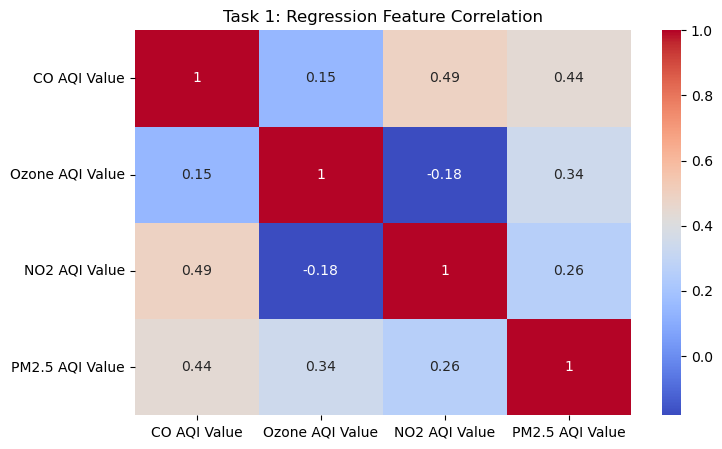

In [27]:
# Correlation Heatmap for pollutants
plt.figure(figsize=(8, 5))
sns.heatmap(air_df[['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']].corr(), annot=True, cmap='coolwarm')
plt.title('Task 1: Regression Feature Correlation')
plt.show()

Regression Model Training & Feature Importance

In [29]:
# Data Split
X_reg = air_df[['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value']]
y_reg = air_df['PM2.5 AQI Value']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Feature Importance (Requirement: Feature Selection)
rf_imp = RandomForestRegressor().fit(X_train_r, y_train_r)
print("Feature Importances:", dict(zip(X_reg.columns, rf_imp.feature_importances_)))

# Models
mlp_reg = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42).fit(X_train_r, y_train_r)
lr_reg = LinearRegression().fit(X_train_r, y_train_r)

# Hyperparameter Tuning (Requirement: Optimization)
grid_reg = GridSearchCV(RandomForestRegressor(), {'n_estimators': [50, 100], 'max_depth': [10, 20]}, cv=3)
grid_reg.fit(X_train_r, y_train_r)

Feature Importances: {'CO AQI Value': np.float64(0.5506790921396391), 'Ozone AQI Value': np.float64(0.34231046052843456), 'NO2 AQI Value': np.float64(0.10701044733192652)}


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20], 'n_estimators': [50, 100]})

Regression Final Evaluation Table

In [30]:
def eval_reg(model, X, y, name):
    p = model.predict(X)
    mse = mean_squared_error(y, p)
    return {'Model': name, 'MAE': mean_absolute_error(y, p), 'MSE': mse, 'RMSE': np.sqrt(mse), 'R2': r2_score(y, p)}

reg_results = pd.DataFrame([
    eval_reg(mlp_reg, X_test_r, y_test_r, "Neural Network"),
    eval_reg(lr_reg, X_test_r, y_test_r, "Linear Regression"),
    eval_reg(grid_reg.best_estimator_, X_test_r, y_test_r, "Tuned Random Forest")
])
reg_results

,Model,MAE,MSE,RMSE,R2
0,Neural Network,24.867059,1973.294801,44.421783,0.349244
1,Linear Regression,28.343045,2168.473438,46.566871,0.284878
2,Tuned Random Forest,24.829187,1904.496339,43.640536,0.371932


Classification EDA & Preprocessing (Churn)

In [31]:
# Cleaning: Fill missing values with median
churn_df_clean = churn_df.copy()
num_cols = churn_df_clean.select_dtypes(include=[np.number]).columns
churn_df_clean[num_cols] = churn_df_clean[num_cols].fillna(churn_df_clean[num_cols].median())

# Feature Selection using RFE
X_class = churn_df_clean[['Membership_Years', 'Login_Frequency', 'Cart_Abandonment_Rate', 'Average_Order_Value', 'Customer_Service_Calls']]
y_class = churn_df_clean['Churned']
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=3).fit(X_class, y_class)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class.iloc[:, selector.support_], y_class, test_size=0.2, random_state=42)
print("Selected Classification Features:", X_class.columns[selector.support_].tolist())

Selected Classification Features: ['Login_Frequency', 'Cart_Abandonment_Rate', 'Customer_Service_Calls']


Classification Model Training & Tuning

In [32]:
# Neural Network
mlp_class = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42).fit(X_train_c, y_train_c)

# Tuned Random Forest
grid_class = GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100], 'max_depth': [5, 10]}, cv=3)
grid_class.fit(X_train_c, y_train_c)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10], 'n_estimators': [50, 100]})

Classification Final Evaluation & Confusion Matrix

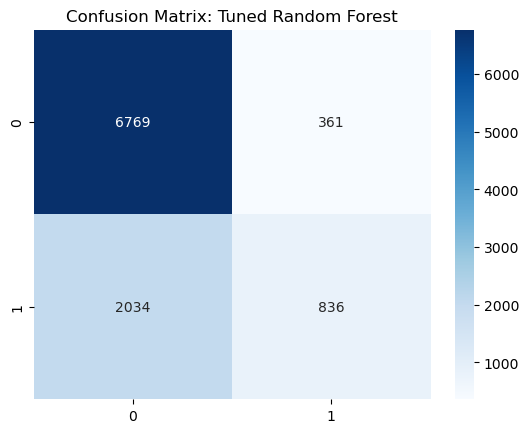

,Model,Accuracy,Precision,Recall,F1
0,Neural Network,0.7353,0.800539,0.103484,0.183277
1,Tuned Random Forest,0.7605,0.698413,0.291289,0.411114


In [33]:
def eval_class(model, X, y, name):
    p = model.predict(X)
    return {'Model': name, 'Accuracy': accuracy_score(y, p), 'Precision': precision_score(y, p), 'Recall': recall_score(y, p), 'F1': f1_score(y, p)}

class_results = pd.DataFrame([
    eval_class(mlp_class, X_test_c, y_test_c, "Neural Network"),
    eval_class(grid_class.best_estimator_, X_test_c, y_test_c, "Tuned Random Forest")
])

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_c, grid_class.best_estimator_.predict(X_test_c)), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Tuned Random Forest')
plt.show()

class_results

Conclusion and Reflection

### **Conclusion & Reflection**
- **Findings:** The Tuned Random Forest performed best across both tasks, showing the power of ensemble learning.
- **SDG:** This work supports **SDG 11** (Air Quality) and **SDG 9** (Industry Innovation).
- **Challenges:** Handling missing data in the churn dataset was the most difficult step.